# Выбор локации для скважины

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

В качестве исходной задачи предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. В заключении необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [3]:
# Импортируем необходимые библиотеки
import pandas as pd 
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from numpy.random import RandomState
from sklearn.metrics import accuracy_score, mean_squared_error

In [4]:
# Выгрузим данные и изучим признаки 
try:
    df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_1 = pd.read_csv('geo_data_0.csv')
    df_2 = pd.read_csv('geo_data_1.csv')
    df_3 = pd.read_csv('geo_data_2.csv')
    
# Вывод пяти первых и последних столбцов датафрейма
display(df_1)
display(df_2)
display(df_3)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Создадим функцию, которая выведет информацию, пропуски, дубликаты, а также построит графики  

In [5]:
# Создание функции для вывода характеристик
def information(df):
    df.info()
    print("\nКоличество пропущенных значений:\n", df.isna().sum())
    print("\nКоличество дубликатов в датафрейме:", df.duplicated().sum())
    df.hist()
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропущенных значений:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов в датафрейме: 0


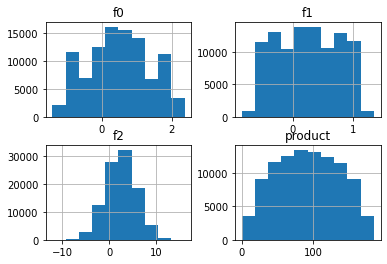

In [6]:
# Вывод информации для первого датафрейма
information(df_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропущенных значений:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов в датафрейме: 0


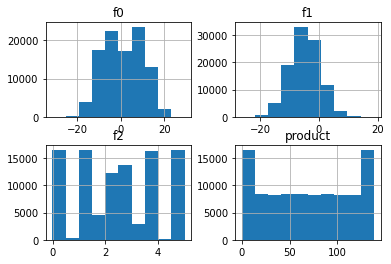

In [7]:
# Вывод информации для второго датафрейма
information(df_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропущенных значений:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов в датафрейме: 0


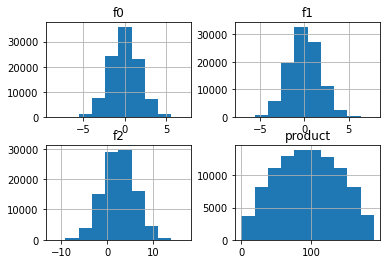

In [8]:
# Вывод информации для третьего датафрейма
information(df_3)

**Вывод:** В таблицах отсутствуют пропущенные значения и дупликаты, дополниельной предобработки не требуется. Данные можно делить на выборки.

## Обучение и проверка модели

In [9]:
# Создадим функцию, которая разделит все датафреймы на обучающие и валидационные выборки
def fragmentation(df):
# Создадим переменные features и target, в котором сохраним необходимые значения, а также уберем лишние столбцы
    features = df.drop(['product','id'], axis=1)
    target = df['product']
    
# Разделим данные на обучающую и валидационные выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=965)
    
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
# Предскажем значения на линейной модели
    model_lir = LinearRegression(normalize=False)
    model_lir.fit(features_train, target_train)
    predictions_valid = model_lir.predict(features_valid)
    
# посчитаем значение метрики RMSE на валидационной выборке
    rmse = mean_squared_error(predictions_valid, target_valid)**0.5
    
   
    print("Значение RMSE:", rmse)
    print("Средний запас предсказанного сырья:", pd.Series(predictions_valid).mean())
    return (predictions_valid, target_valid, rmse)

In [10]:
# Полученные значения для первого региона
fragmentation(df_1);

Значение RMSE: 37.53072453087932
Средний запас предсказанного сырья: 92.18600823266576


In [11]:
# Полученные значения для второго региона
fragmentation(df_2);

Значение RMSE: 0.8949337294995479
Средний запас предсказанного сырья: 68.52989190223066


In [12]:
# Полученные значения для третьего региона
fragmentation(df_3);

Значение RMSE: 39.91048566221276
Средний запас предсказанного сырья: 95.12818771117546


**Вывод:** Наибольшее значение RMSE и среднего запаса предсказанного сырья показывает третий регион (RMSE=39,9) (запас предсказанного сырья = 95,12), наименьшие показатели имеет второй регион (RMSE=0,89) (запас предсказанного сырья = 68,5)

## Подготовка к расчёту прибыли

In [13]:
# Сохраним необходимые значения в отдельные переменные
predictions_df1, validation_df1, rmse_df1 = fragmentation(df_1)
predictions_df2, validation_df2, rmse_df2 = fragmentation(df_2)
predictions_df3, validation_df3, rmse_df3 = fragmentation(df_3)

Значение RMSE: 37.53072453087932
Средний запас предсказанного сырья: 92.18600823266576
Значение RMSE: 0.8949337294995479
Средний запас предсказанного сырья: 68.52989190223066
Значение RMSE: 39.91048566221276
Средний запас предсказанного сырья: 95.12818771117546


In [14]:
# Выведем несколько элементов
print(predictions_df1)
print(validation_df2)
print(rmse_df3)

[ 84.72994381  94.24550382  88.87932703 ...  90.79866582 110.77803807
  58.39268517]
41545     26.953261
73185      0.000000
63507     26.953261
74025    107.813044
46511    107.813044
            ...    
33292     84.038886
65955     84.038886
20982    110.992147
92459      3.179103
3763      57.085625
Name: product, Length: 25000, dtype: float64
39.91048566221276


Теперь необходимо рассчитать достаточный объём сырья для безубыточной разработки новой скважины.
Определимся с характеристиками:
* Бюджет на разработку скважин в регионе составлет 10 млрд рублей, с помощью машинного обучения выбираются 200 наилучших скважин и для того, чтобы получить средний объем в скважине нужно разделить бюджет на 200.
* Цена одного барреля сырья составляет 450 рублей, объем указывается в тысячах баррелей, следовательно цена будет составлять 450 тыс. рублей.
Для расчета безубыточной разработки новой скважины поделим величину бюджета на стоимость одной тысячи бареллей

In [15]:
# Бюджет на разработку скважин 
budget = (10**10)
# Цена 1000 барралей
price_barrels = 450 * 1000

volum = budget / price_barrels
print("Достаточный объём сырья для безубыточной разработки:", volum)

Достаточный объём сырья для безубыточной разработки: 22222.222222222223


In [16]:
# Теперь рассчитаем средний объем в скважине для безубыточного функционирования 
average_volume = volum / 200
print("Средний объем в скважине для безубыточного функционирования", average_volume)

Средний объем в скважине для безубыточного функционирования 111.11111111111111


**Вывод:** В ходе приведенных решений стоит отметить, что запас сырья в скважинах намного меньше, чем достаточный сырья для безубыточной разработки.

## Расчёт прибыли и рисков 

Напишем функцию. На вход данная функция будет получать:
* Список ответов target
* Средний запас предсказанного сырья predictions

In [17]:
top_points = 200
points = 500

In [18]:
# Функция для предсказания прибыли 
def profit_bore(target, predictions):
    target = target.reset_index(drop=True)
    predictions = pd.Series(predictions, index=target.index)
    top_predictions = predictions.sort_values(ascending=False)
    # Выбираем 200 наилучших точек
    top_fields = target[top_predictions.index][:top_points]
    # Считаем полученный доход 
    revenue = top_fields.sum() * price_barrels
    
    return (revenue - budget) / 10**9

In [27]:
def predictions_region(target, predictions):
    values = []
    state = RandomState(965)
    for i in range(1000):
        target_sample = target.reset_index(drop=True).sample(n=points, replace=True, random_state=state)
        probs_sample = predictions[target_sample.index]
        res = profit_bore(target_sample, probs_sample)
        values.append(res)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    mean_revenue = values.mean()
    interval = values.quantile(0), values.quantile(1)
    risk = (values < 0).mean()
    print(f'\nДоверительный интервал: {interval} млрд.рублей')
    print(f'\n95,7% квантиль: {higher} млрд.рублей')
    print(f'\n2,5% квантиль: {lower} млрд.рублей')
    print(f'\nсредняя прибыль: {mean_revenue} млрд.рублей')
    print(f'\nриск убытков: {risk: .1%}')

In [28]:
# Получаем значения рассчитанной прибыли и сохраняем их в отдельные переменные
profit_region_1 = profit_bore(validation_df1, predictions_df1)
profit_region_2 = profit_bore(validation_df2, predictions_df2)
profit_region_3 = profit_bore(validation_df3, predictions_df3)

# Выведем полученные значения с помощью функции
i = 1
for profit_region in [profit_region_1,
                      profit_region_2, 
                      profit_region_3]:
    print(f' Прибиль от добычи сырья в {i}-ом регионе: {profit_region} млрд.руб.')
    i+=1


 Прибиль от добычи сырья в 1-ом регионе: 3.303133141604578 млрд.руб.
 Прибиль от добычи сырья в 2-ом регионе: 2.4150866966815108 млрд.руб.
 Прибиль от добычи сырья в 3-ом регионе: 2.56530799298164 млрд.руб.


**Вывод:** Наибольшая прибыль от добычи сырья будет в первом регионе, а наименьшая, во втором

In [36]:
predictions_region_1 = predictions_region(validation_df1, predictions_df1)


Доверительный интервал: (-0.3009635994465427, 1.2492274553363076) млрд.рублей

95,7% квантиль: 0.9558072070352975 млрд.рублей

2,5% квантиль: -0.034471715989000354 млрд.рублей

средняя прибыль: 0.46367571033343224 млрд.рублей

риск убытков:  3.6%


In [33]:
predictions_region_2 = predictions_region(validation_df2, predictions_df2)


Доверительный интервал: (-0.15656540489312362, 0.9949401062074031) млрд.рублей

95,7% квантиль: 0.8316391092603347 млрд.рублей

2,5% квантиль: 0.01362111358361694 млрд.рублей

средняя прибыль: 0.41068413586690866 млрд.рублей

риск убытков:  2.1%


In [35]:
predictions_region_3 = predictions_region(validation_df3, predictions_df3)


Доверительный интервал: (-0.3810998155359497, 1.132481745561056) млрд.рублей

95,7% квантиль: 0.8703333685021478 млрд.рублей

2,5% квантиль: -0.136601896024789 млрд.рублей

средняя прибыль: 0.3626701961267375 млрд.рублей

риск убытков:  9.3%


**Вывод:** С помощью процедуры бутстрэпа найден 95% доверительный интервал для среднего объема нефти в скважинах. Наиболее перспективным для разработки представляется регион № 2, поскольку риски убытков для данного регина незначительны.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: модели обучены и проверены
    - [X]  Данные корректно разбиты на обучающую и валидационную выборки
    - [X]  Модели обучены, предсказания сделаны
    - [X]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [X]  На экране напечатаны результаты
    - [X]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [X]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [X]  По предыдущему пункту сделаны выводы
    - [X]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [X]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [X]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован